In [1]:
# !pip install --quiet --pre dgl-cu101
# !pip install --quiet catboost
# !pip install --quiet category-encoders==2.2.2
# !pip install --quiet /mnt/dgl_cu102-0.6.0-cp36-cp36m-manylinux1_x86_64.whl
# !pip install --quiet torch==1.6.0

In [1]:
import argparse
import itertools
import time
import math
import pickle
import random
from tqdm import tqdm
tqdm.pandas(position=0, leave=True)

from collections import defaultdict as ddict
import pandas as pd
import numpy as np
from numpy import save,load,savetxt,loadtxt,savez_compressed
import json
import os

from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize

import catboost
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, sum_models
# import category_encoders
# from category_encoders import CatBoostEncoder

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'
import warnings
warnings.filterwarnings('ignore')
import utils
# import tsne_func

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import dgl
import dgl.nn as dglnn
import dgl.function as Fn

data_dir="/workspace/cjiang/eagle_project/CAP_graph/dataset/"
root_dir="/workspace/cjiang/eagle_project/CAP_graph/BGNN/"

os.chdir(root_dir)

print(catboost.__version__)
# print(category_encoders.__version__)
print(torch.__version__)

Using backend: pytorch


0.20.1
1.6.0


In [2]:
def seed_everything(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(101)

In [3]:
KG_dir="/workspace/cjiang/eagle_project/CAP_graph/BGNN/"

start=time.time()
with open(os.path.join(KG_dir,'CAP_Graph_07082021'), 'rb') as f:
    G,multi_label,binary_label,\
    train_mask_multi_label,  val_mask_multi_label,  test_mask_multi_label,\
    train_mask_binary_label, val_mask_binary_label, test_mask_binary_label= pickle.load(f)
end=time.time()
print("It took {:0.4f} seconds to load graph".format(end-start))

It took 23.2669 seconds to load graph


In [4]:
tempt=pd.DataFrame()
tempt['segment']=G.nodes['usaanr'].data['Segment'].squeeze().numpy()
tempt['auto_policy']=binary_label.squeeze().numpy()
tempt.head(2)

,segment,auto_policy
0,1,1
1,5,0


In [5]:
tempt.groupby("segment")['auto_policy'].count()

segment
0     1650589
1     1571682
2     1342896
3     1237712
4     1017241
5    18848384
Name: auto_policy, dtype: int64

In [7]:
G

Graph(num_nodes={'usaanr': 25668504},
      num_edges={('usaanr', 'AUTO_RELATED', 'usaanr'): 7947060, ('usaanr', 'Brother_Sister', 'usaanr'): 651444, ('usaanr', 'Busi_rel_Other', 'usaanr'): 1039214, ('usaanr', 'Child', 'usaanr'): 11765795, ('usaanr', 'Ex-Spouse', 'usaanr'): 3877972, ('usaanr', 'Parent', 'usaanr'): 11765795, ('usaanr', 'Pers_rel_Other', 'usaanr'): 2012514, ('usaanr', 'SPONSEE', 'usaanr'): 16775141, ('usaanr', 'SPONSOR', 'usaanr'): 16775141, ('usaanr', 'Spouse', 'usaanr'): 16016119, ('usaanr', 'Step-Child', 'usaanr'): 1240193, ('usaanr', 'Step-Parent', 'usaanr'): 1240193},
      metagraph=[('usaanr', 'usaanr', 'AUTO_RELATED'), ('usaanr', 'usaanr', 'Brother_Sister'), ('usaanr', 'usaanr', 'Busi_rel_Other'), ('usaanr', 'usaanr', 'Child'), ('usaanr', 'usaanr', 'Ex-Spouse'), ('usaanr', 'usaanr', 'Parent'), ('usaanr', 'usaanr', 'Pers_rel_Other'), ('usaanr', 'usaanr', 'SPONSEE'), ('usaanr', 'usaanr', 'SPONSOR'), ('usaanr', 'usaanr', 'Spouse'), ('usaanr', 'usaanr', 'Step-Child')

In [8]:
df=pd.DataFrame()
df['usaayr']=G.nodes['usaanr'].data['usaayr'].squeeze().numpy()
df['AGE_BAND']=G.nodes['usaanr'].data['AGE_BAND'].squeeze().numpy()
df['ORIGEL']=G.nodes['usaanr'].data['ORIGEL'].squeeze().numpy()
df['ELIG2']=G.nodes['usaanr'].data['ELIG2'].squeeze().numpy()
df['SEX']=G.nodes['usaanr'].data['SEX'].squeeze().numpy()
df['MARST']=G.nodes['usaanr'].data['MARST'].squeeze().numpy()
df['BRANCH']=G.nodes['usaanr'].data['BRANCH'].squeeze().numpy()
df['MILST']=G.nodes['usaanr'].data['MILST'].squeeze().numpy()
df['MLIST_OrigStat']=G.nodes['usaanr'].data['MLIST_OrigStat'].squeeze().numpy()
df['ENLPAYGD']=G.nodes['usaanr'].data['ENLPAYGD'].squeeze().numpy()
df['STATE']=G.nodes['usaanr'].data['STATE'].squeeze().numpy()
df.head(2)

,usaayr,AGE_BAND,ORIGEL,ELIG2,SEX,MARST,BRANCH,MILST,MLIST_OrigStat,ENLPAYGD,STATE
0,29,5,0,0,1,2,1,2,2,14,32
1,54,4,24,5,1,2,0,0,2,24,45


In [9]:
df.columns

Index(['usaayr', 'AGE_BAND', 'ORIGEL', 'ELIG2', 'SEX', 'MARST', 'BRANCH',
       'MILST', 'MLIST_OrigStat', 'ENLPAYGD', 'STATE'],
      dtype='object')

In [11]:
feat=['usaayr','AGE_BAND','ORIGEL', 'ELIG2', 'SEX', 'MARST','BRANCH',\
      'MILST','MLIST_OrigStat','ENLPAYGD','STATE','ZIPCD']

df=df.loc[:,feat]

for col in df:
    df[col]=df[col].astype('str')

class_le=LabelEncoder()

for i in tqdm(range(len(df.columns)),position=0,leave=True):
    col=df.columns[i]
    if df[col].dtype=="object":
        df[col]=df[col].astype('str')
        df[col]=class_le.fit_transform(df[col])
        
categorical_index=np.where(df.dtypes==object)[0]
categorical_index

100%|██████████| 12/12 [03:22<00:00, 16.89s/it]


array([], dtype=int64)

In [20]:
# def encode_cat_features(X, y, cat_features, train_mask, val_mask, test_mask):
#     enc = CatBoostEncoder()
#     A = X.to_numpy(copy=True)
#     b = y.to_numpy(copy=True)
#     A[np.ix_(train_mask, cat_features)] = enc.fit_transform(A[np.ix_(train_mask, cat_features)], b[train_mask])
#     A[np.ix_(val_mask + test_mask, cat_features)] = enc.transform(A[np.ix_(val_mask + test_mask, cat_features)])
#     A = A.astype(float)
#     return pd.DataFrame(A, columns=X.columns)

In [12]:
def lift_gain_eval(logit,label,topk):
    DF=pd.DataFrame(columns=["pred_score","actual_label"])
    DF["pred_score"]=logit
    DF["actual_label"]=label
    DF.sort_values(by="pred_score", ascending=False, inplace=True)
    gain={}
    for p in topk:
        N=math.ceil(int(DF.shape[0]*p))
        DF2=DF.nlargest(N,"pred_score",keep="first")
        gain[str(int(p*100))+"%"]=round(DF2.actual_label.sum()/(DF.actual_label.sum()),2)
    return gain

def get_class_count_weight(y,n_classes):
    classes_count=[]
    weight=[]
    for i in range(n_classes):
        count=np.sum(y.squeeze()==i)
        classes_count.append(count)
        weight.append(len(y)/(n_classes*count))
    return classes_count,weight

def evaluate(target, predicted):
    true_label_mask=[1 if (np.argmax(x)-target[i])==0 else 0 for i,x in enumerate(predicted)]
    nb_prediction=len(true_label_mask)
    true_prediction=sum(true_label_mask)
    false_prediction=nb_prediction-true_prediction
    accuracy=true_prediction/nb_prediction
    
    precision, recall, fscore, support = precision_recall_fscore_support(target, predicted.argmax(axis=1))
    auc = roc_auc_score(target.ravel(), torch.sigmoid(torch.from_numpy(predicted))[:,1].numpy().ravel())
    
    prec,rec,_ = precision_recall_curve(target.ravel(), torch.sigmoid(torch.from_numpy(predicted))[:,1].numpy().ravel())
    
    pr_auc=auc_score(rec,prec)
    
    arg1=predicted[:,1]
    arg2=target
    gain = lift_gain_eval(arg1,arg2,topk=[0.01,0.05,0.10])
    
    return {
        "nb_example":len(target),
        "true_prediction":true_prediction,
        "false_prediction":false_prediction,
        "accuracy":accuracy,
        "precision":precision[1], 
        "recall":recall[1], 
        "f1_score":fscore[1],
        "AUC":auc,
        "pr_auc":pr_auc,
        "GAIN":gain
    }

#### LABEL

In [13]:
y=binary_label.squeeze().numpy()
n_classes=torch.unique(binary_label).shape[0]
classes_count,weight=get_class_count_weight(y,n_classes)
imbalance_classes={}
# imbalance_classes["category"]=torch.unique(binary_label).tolist()
imbalance_classes["Auto or Not"]=["No","Yes"]
imbalance_classes["count"]=classes_count
imbalance_classes["weight"]=weight
imbalance_classes=pd.DataFrame(imbalance_classes)
imbalance_classes.style.format({"count":"{:,}","weight":"{:.2f}"})

,Auto or Not,count,weight
0,No,"19,358,913",0.66
1,Yes,"6,309,591",2.03


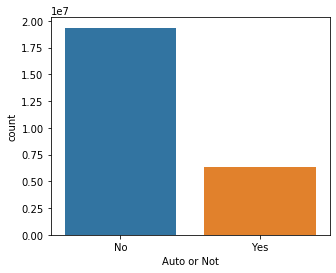

In [14]:
import seaborn as sns
sns.barplot(x="Auto or Not",y="count",data=imbalance_classes)

#### setting up Training, Validation and Test set

In [15]:
train_idx=torch.nonzero(train_mask_binary_label.squeeze()).numpy()
val_idx=torch.nonzero(val_mask_binary_label.squeeze()).numpy()
test_idx=torch.nonzero(test_mask_binary_label.squeeze()).numpy()

train_idx=torch.from_numpy(train_idx).squeeze()    
val_idx=torch.from_numpy(val_idx).squeeze()    
test_idx=torch.from_numpy(test_idx).squeeze()

label_train=binary_label[train_idx].squeeze().numpy()
label_val=binary_label[val_idx].squeeze().numpy()
label_test=binary_label[test_idx].squeeze().numpy()

df_train=df.loc[train_idx,:]
df_val=df.loc[val_idx,:]
df_test=df.loc[test_idx,:]

print('{:<15} {:<10,}'.format("Training set",train_idx.shape[0]))
print('{:<15} {:<10,}'.format("validation set",val_idx.shape[0]))
print('{:<15} {:<10,}'.format("test set",test_idx.shape[0]))

Training set    20,534,804
validation set  2,566,850 
test set        2,566,850 


In [16]:
# tempt=df_train
# tempt["auto_policy"]=label_train
# # tempt.head(2)

# tempt.groupby("Segment")["auto_policy"].sum()

In [17]:
num_classes=torch.unique(torch.from_numpy(label_train)).shape[0]
train_classes_num, train_classes_weight = get_class_count_weight(label_train,num_classes)

In [18]:
%%time
params = {'loss_function':'MultiClass',
         'learning_rate' : 0.01,
         'iterations' : 3000,
         'cat_features' : categorical_index,
         'early_stopping_rounds'  : 200,
         'random_seed' : 101,
         'task_type' : "GPU",
         'class_weights':train_classes_weight,
         'verbose' : 200}

model=CatBoostClassifier(**params)
model.fit(df_train, label_train, eval_set=(df_val,label_val),use_best_model=True,early_stopping_rounds=50)

0:	learn: 0.6897757	test: 0.6897786	best: 0.6897786 (0)	total: 58.8ms	remaining: 2m 56s
200:	learn: 0.4880490	test: 0.4878634	best: 0.4878634 (200)	total: 8.31s	remaining: 1m 55s
400:	learn: 0.4689548	test: 0.4688118	best: 0.4688118 (400)	total: 16.6s	remaining: 1m 47s
600:	learn: 0.4630101	test: 0.4629009	best: 0.4629009 (600)	total: 25s	remaining: 1m 39s
800:	learn: 0.4594386	test: 0.4593547	best: 0.4593547 (800)	total: 33.5s	remaining: 1m 31s
1000:	learn: 0.4568814	test: 0.4568266	best: 0.4568266 (1000)	total: 41.9s	remaining: 1m 23s
1200:	learn: 0.4551188	test: 0.4550915	best: 0.4550915 (1200)	total: 50.4s	remaining: 1m 15s
1400:	learn: 0.4537791	test: 0.4537744	best: 0.4537744 (1400)	total: 58.8s	remaining: 1m 7s
1600:	learn: 0.4527281	test: 0.4527400	best: 0.4527400 (1600)	total: 1m 7s	remaining: 58.6s
1800:	learn: 0.4518669	test: 0.4518891	best: 0.4518891 (1800)	total: 1m 15s	remaining: 50.1s
2000:	learn: 0.4511046	test: 0.4511374	best: 0.4511374 (2000)	total: 1m 23s	remaining: 

In [19]:
preds_proba_test = model.predict_proba(df_test)

prec_test, recall_test, fscore_test, support_test = precision_recall_fscore_support(label_test, preds_proba_test.argmax(axis=1))
test_auc = roc_auc_score(label_test, preds_proba_test[:,1])

prec, rec,_=precision_recall_curve(label_test, preds_proba_test[:,1])
test_pr_auc=auc_score(rec,prec)

print("Test Set Performance")
print("precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | ROC_AUC: {:.1%} | PR_AUC: {:.1%}"\
      .format(prec_test[1], recall_test[1], fscore_test[1],  test_auc, test_pr_auc))

Test Set Performance
precision: 48.45% | recall: 82.45% | F1_score: 61.04% | ROC_AUC: 85.7% | PR_AUC: 64.7%


#### Performance Evaluation

In [24]:
LOGIT_train = model.predict_proba(df_train)
LABEL_train = label_train
train_PV=evaluate(LABEL_train, LOGIT_train)
train_PV

{'nb_example': 20534804,
 'true_prediction': 15221080,
 'false_prediction': 5313724,
 'accuracy': 0.7412332740064137,
 'precision': 0.48451878657535663,
 'recall': 0.8248012500017334,
 'f1_score': 0.6104415874692035,
 'AUC': 0.8565397671732771,
 'pr_auc': 0.6461057942011375,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.3}}

In [25]:
LOGIT_val = model.predict_proba(df_val)
LABEL_val = label_val
val_PV=evaluate(LABEL_val, LOGIT_val)
val_PV

{'nb_example': 2566850,
 'true_prediction': 1902187,
 'false_prediction': 664663,
 'accuracy': 0.7410588854042893,
 'precision': 0.4843088617872553,
 'recall': 0.8243625972527533,
 'f1_score': 0.6101548382026123,
 'AUC': 0.8563962739590291,
 'pr_auc': 0.6464814616538147,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.3}}

In [26]:
LOGIT_test = model.predict_proba(df_test)
LABEL_test = label_test
test_PV=evaluate(LABEL_test, LOGIT_test)
test_PV

{'nb_example': 2566850,
 'true_prediction': 1902677,
 'false_prediction': 664173,
 'accuracy': 0.7412497808598087,
 'precision': 0.4845324337363761,
 'recall': 0.8245004825987109,
 'f1_score': 0.6103700227322725,
 'AUC': 0.8567869679774657,
 'pr_auc': 0.6468921970183911,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.3}}

#### Model Save

In [2]:
if not os.path.exists("model_save"):
    os.makedirs("model_save")

In [20]:
# if not os.path.exists("/mnt/bgnn/model_save/"):
#     os.makedirs("/mnt/bgnn/model_save/")
# model.save_model("/mnt/bgnn/model_save/CatBoost")
# !hdfs dfs -put -f /mnt/bgnn/model_save/CatBoost  /dz/dz_6104/disc.db/BGNN/CatBoost
# os.system("rm /mnt/bgnn/model_save/CatBoost")

#### Score Test Dataset

In [21]:
%%time
# if not os.path.exists("/mnt/bgnn/model_save/"):
#     os.makedirs("/mnt/bgnn/model_save/")
    
LOGIT_test = model.predict_proba(df_test)
LABEL_test = label_test

# savez_compressed("/mnt/bgnn/model_save/Catboost_LOGIT.npz", LOGIT_test)
# savez_compressed("/mnt/bgnn/model_save/Catboost_LABEL.npz", LABEL_test)
# !hdfs dfs -put -f /mnt/bgnn/model_save/Catboost_LOGIT.npz  /dz/dz_6104/disc.db/BGNN/Catboost_LOGIT.npz
# !hdfs dfs -put -f /mnt/bgnn/model_save/Catboost_LABEL.npz  /dz/dz_6104/disc.db/BGNN/Catboost_LABEL.npz
# os.system("rm /mnt/bgnn/model_save/Catboost_LOGIT.npz")
# os.system("rm /mnt/bgnn/model_save/Catboost_LABEL.npz")

CPU times: user 32.7 s, sys: 316 ms, total: 33 s
Wall time: 3.34 s


In [22]:
# path="/home/ubuntu"
# if not os.path.isfile(os.path.join(path,"Catboost_LOGIT.npz")):
#     !hdfs dfs -get  /dz/dz_6104/disc.db/BGNN/Catboost_LOGIT.npz     /home/ubuntu
#     !hdfs dfs -get  /dz/dz_6104/disc.db/BGNN/Catboost_LABEL.npz     /home/ubuntu

# fin_logits_graph = load("/home/ubuntu/Catboost_LOGIT.npz")['arr_0']
# fin_targets_graph = load("/home/ubuntu/Catboost_LABEL.npz")['arr_0']

fin_logits_graph = LOGIT_test
fin_targets_graph = LABEL_test

tmp_graph=evaluate(fin_targets_graph, fin_logits_graph)
print("")
print("==> Running Validation on validation set \n")
print("")

print("True_Prediction: {:,} | False_Prediction: {:,} | accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-10%: {:.1f} |\
ROC_AUC: {:.1%} | PR_AUC: {:.1%}".format(tmp_graph["true_prediction"], tmp_graph["false_prediction"], tmp_graph["accuracy"], \
                                                        tmp_graph["precision"], tmp_graph["recall"], tmp_graph["f1_score"], tmp_graph["GAIN"]['10%'], \
                                                        tmp_graph["AUC"], tmp_graph["pr_auc"]))


==> Running Validation on validation set 


True_Prediction: 1,902,677 | False_Prediction: 664,173 | accuracy: 74.12% |  precision: 48.45% | recall: 82.45% | F1_score: 61.04% | Gain_top-10%: 0.3 |ROC_AUC: 85.7% | PR_AUC: 64.7%


In [23]:
tmp_graph

{'nb_example': 2566850,
 'true_prediction': 1902677,
 'false_prediction': 664173,
 'accuracy': 0.7412497808598087,
 'precision': 0.4845324337363761,
 'recall': 0.8245004825987109,
 'f1_score': 0.6103700227322725,
 'AUC': 0.8567869679774657,
 'pr_auc': 0.6468921970183911,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.3}}